## EXERCISE 3

Study the data in the file x_XGB_24.dat (N=2000 samples) with labels y_XGB_24.dat. The dataset should be split into N' training samples and N'' validation samples, with N' + N'' = N

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier

# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier

# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

# GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


In [2]:
np.random.seed(12345)

dname = "./DATA/"
str0 = "_XGB_24.dat"
fnamex = dname + 'x' + str0
fnamey = dname + 'y' + str0
x = np.loadtxt(fnamex, delimiter = " ", dtype = float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N, L = len(x), len(x[0])

N_train = int(0.75*N)
x_train, y_train = x[:N_train], y[:N_train]
x_val, y_val = x[N_train:], y[N_train:]
print(f"N = {N}, N_train = {N_train}, L = {L}")

N = 4000, N_train = 3000, L = 4


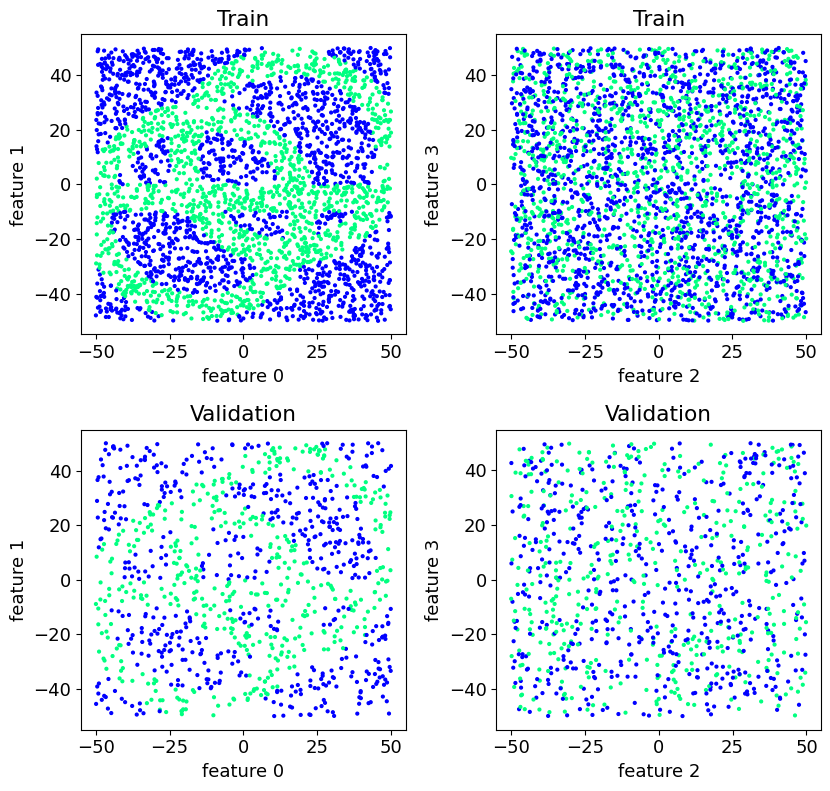

In [3]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

fig, AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_val,y_val,title="Validation")
scat(AX[1,1],x_val,y_val,i=2,j=3,title="Validation")
fig.tight_layout()
plt.show()

### 1\. Model complexity, parameters’ and regularization
Try different parameters (λ, γ, n_estimators, ...). Which is the simplest yet effective XGBoost model that keeps a good validation accuracy? Is regularization useful for this analysis?

In [4]:
def classify(clf=GradientBoostingClassifier(),show=False):
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_val)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_val, y_val)), clf.score(x_val, y_val)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig, AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()

errors: 5.20%   Accuracy=0.948


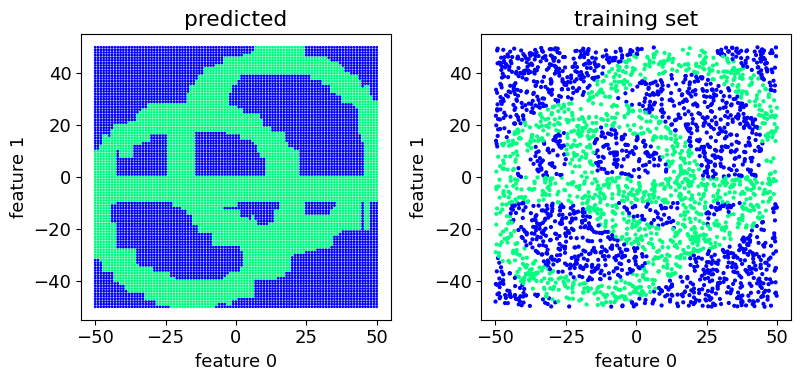

num_trees= 100


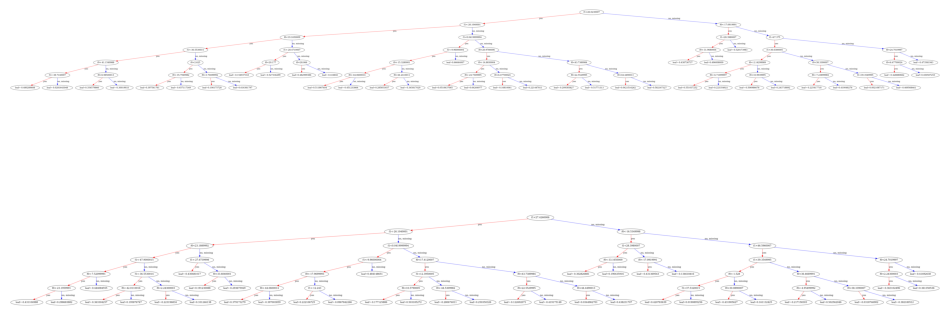

In [5]:
model = XGBClassifier(seed=1, 
                      objective='binary:logistic')

classify(model, show=True)

In [6]:
# FUNCTION FOR LOOKING FOR THE BEST MODEL

def find_best_model(x_train, y_train, x_val, y_val):
    parameters = {
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'n_estimators': [10, 50, 100, 150, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'reg_lambda': [0.001, 0.01, 0.1, 0],
        'reg_alpha': [0.001, 0.01, 0.1, 0],
        'gamma': [0, 0.1, 0.2, 0.3]
    }

    model = XGBClassifier(seed=1, objective='binary:logistic')
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=3, scoring='accuracy')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Accuracy on Training Set:", best_score)

    # Train the model on the combined training and validation set using best parameters
    best_model = XGBClassifier(**best_params, seed=1, objective='binary:logistic')
    best_model.fit(x_train, y_train)

    # Evaluate the best model on the validation set
    y_pred_val = best_model.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    print("Accuracy on Validation Set:", val_accuracy)

    return best_model, best_params, val_accuracy

In [7]:
# FIND BEST MODEL AND BEST PARAMETERS

best_model, best_params, validation_accuracy = find_best_model(x_train, y_train, x_val, y_val)

Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 0}
Best Accuracy on Training Set: 0.9273333333333333
Accuracy on Validation Set: 0.953


errors: 4.70%   Accuracy=0.953


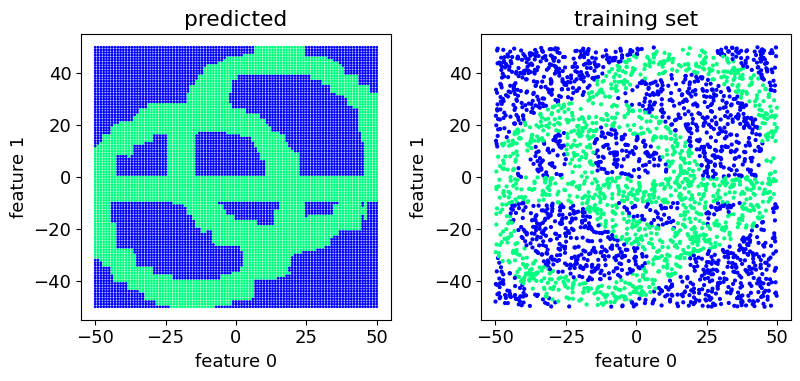

num_trees= 200


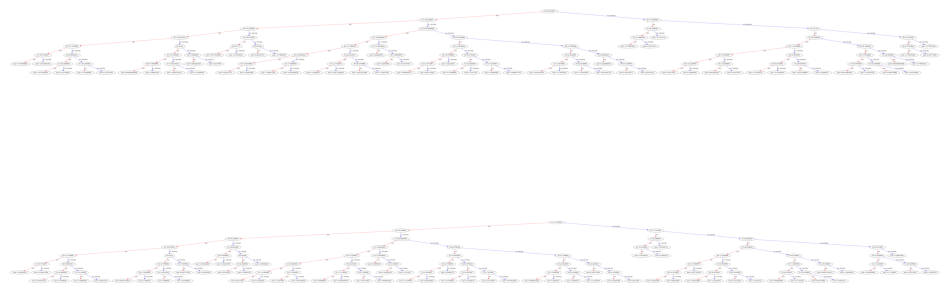

Validation Accuracy without Regularization: 0.948
Validation Accuracy with Regularization: 0.953


In [8]:
# CHECK IF THE REGULARIZATION IS HELPFUL

classify(best_model, show = True)

xgb_model_no_reg = XGBClassifier()
xgb_model_no_reg.fit(x_train, y_train)
y_pred_no_reg = xgb_model_no_reg.predict(x_val)
accuracy_no_reg = accuracy_score(y_val, y_pred_no_reg)

print("Validation Accuracy without Regularization:", accuracy_no_reg)
print("Validation Accuracy with Regularization:", validation_accuracy)

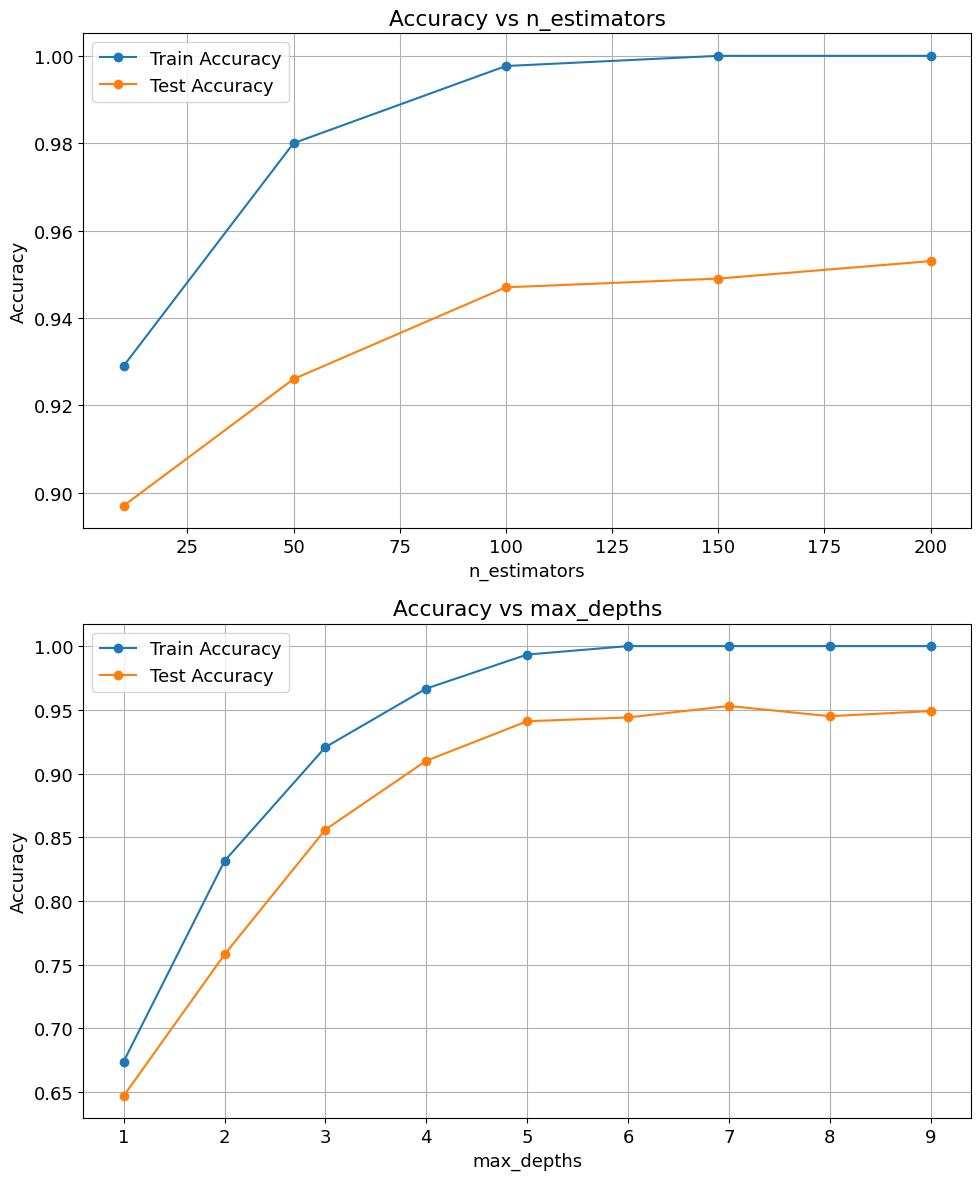

In [9]:
n_estimators = [10, 50, 100, 150, 200]
max_depths_range = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot for n_estimators
train_accuracies = []
val_accuracies = []

for num in n_estimators:
    model = XGBClassifier(learning_rate=best_params['learning_rate'],
                          n_estimators=num,
                          max_depth=best_params['max_depth'],
                          reg_lambda=best_params['reg_lambda'],
                          reg_alpha=best_params['reg_alpha'],
                          gamma=best_params['gamma'],
                          seed=1,
                          objective='binary:logistic')

    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    y_test_pred = model.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_test_pred)
    val_accuracies.append(val_accuracy)

axes[0].plot(n_estimators, train_accuracies, marker='o', label='Train Accuracy')
axes[0].plot(n_estimators, val_accuracies, marker='o', label='Test Accuracy')
axes[0].set_title('Accuracy vs n_estimators')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot for max_depths
train_accuracies = []
val_accuracies = []

for max_depth in max_depths_range:
    model = XGBClassifier(learning_rate=best_params['learning_rate'],
                          n_estimators=best_params['n_estimators'],
                          max_depth=max_depth,
                          reg_lambda=best_params['reg_lambda'],
                          reg_alpha=best_params['reg_alpha'],
                          gamma=best_params['gamma'],
                          seed=1,
                          objective='binary:logistic')

    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    y_test_pred = model.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_test_pred)
    val_accuracies.append(val_accuracy)

axes[1].plot(max_depths_range, train_accuracies, marker='o', label='Train Accuracy')
axes[1].plot(max_depths_range, val_accuracies, marker='o', label='Test Accuracy')
axes[1].set_title('Accuracy vs max_depths')
axes[1].set_xlabel('max_depths')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

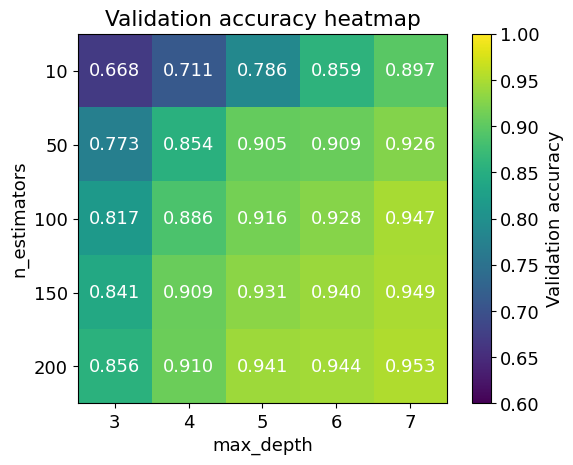

In [10]:
n_estimators = [10, 50, 100, 150, 200]
max_depth = [3, 4, 5, 6, 7]
accuracies = np.zeros((len(n_estimators), len(max_depth)))

for i, num in enumerate(n_estimators):
    for j, depth in enumerate(max_depth):
        model = XGBClassifier(learning_rate=best_params['learning_rate'], 
                              n_estimators=num, 
                              max_depth=depth, 
                              reg_lambda=best_params['reg_lambda'], 
                              reg_alpha=best_params['reg_alpha'], 
                              gamma=best_params['gamma'], 
                              seed=1, 
                              objective='binary:logistic')
        model.fit(x_train, y_train)
        y_pred_test = model.predict(x_val)
        val_accuracy = accuracy_score(y_val, y_pred_test)
        accuracies[i, j] = val_accuracy

plt.imshow(accuracies, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Validation accuracy')
plt.yticks(np.arange(len(n_estimators)), n_estimators)
plt.xticks(np.arange(len(max_depth)), max_depth)
plt.ylabel('n_estimators')
plt.xlabel('max_depth')
plt.title('Validation accuracy heatmap')
plt.clim(0.6, 1)

# Adding text annotations
for i in range(len(n_estimators)):
    for j in range(len(max_depth)):
        plt.text(j, i, f'{accuracies[i, j]:.3f}', ha='center', va='center', color='white')

plt.show()

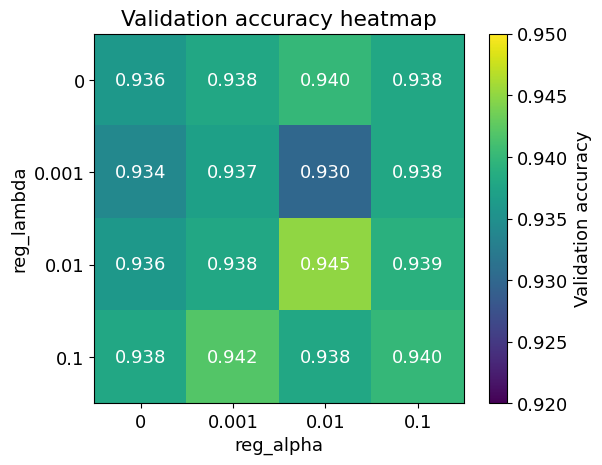

In [18]:
reg_lambda = [0, 0.001, 0.01, 0.1]
reg_alpha = [0, 0.001, 0.01, 0.1]
accuracies = np.zeros((len(reg_lambda), len(reg_alpha)))

for i, lambd in enumerate(reg_lambda):
    for j, alpha in enumerate(reg_alpha):
        model = XGBClassifier(learning_rate=best_params['learning_rate'], 
                              n_estimators=150, 
                              max_depth=6, 
                              reg_lambda=lambd, 
                              reg_alpha=alpha, 
                              gamma=best_params['gamma'], 
                              seed=1, 
                              objective='binary:logistic')
        model.fit(x_train, y_train)
        y_pred_test = model.predict(x_val)
        val_accuracy = accuracy_score(y_val, y_pred_test)
        accuracies[i, j] = val_accuracy

plt.imshow(accuracies, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Validation accuracy')
plt.xticks(np.arange(len(reg_alpha)), reg_alpha)
plt.yticks(np.arange(len(reg_lambda)), reg_lambda)
plt.xlabel('reg_alpha')
plt.ylabel('reg_lambda')
plt.title('Validation accuracy heatmap')
plt.clim(0.92, 0.95)


for i in range(len(reg_lambda)):
    for j in range(len(reg_alpha)):
        plt.text(j, i, f'{accuracies[i, j]:.3f}', ha='center', va='center', color='white')

plt.show()

errors: 5.50%   Accuracy=0.945


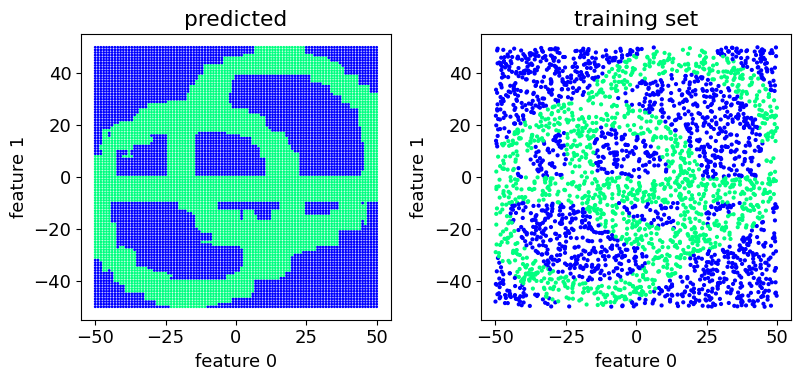

num_trees= 150


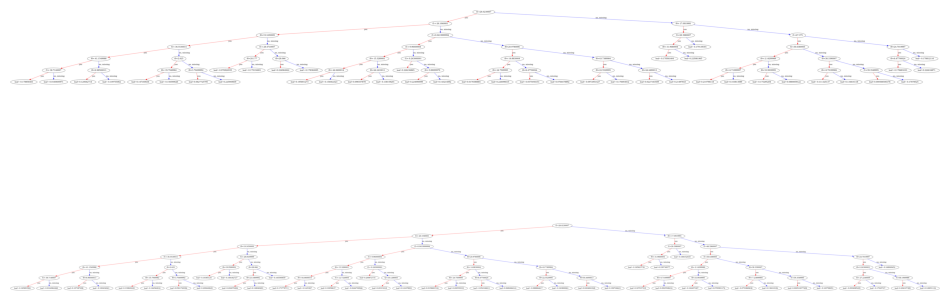

In [12]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      # importance_type="gain" #weight, cover, ...
                      learning_rate= best_params['learning_rate'], 
                      gamma = best_params['gamma'],
                      reg_lambda=0.01, 
                      reg_alpha = 0.01,
                      n_estimators=150,
                      max_depth=6)

classify(model, show=True)

### Answer

We studied how the validation accuracy changes for different parameters of the XGBoost classifier; the best paramaters are: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 0}, which give a validation accuracy of 0.953.

Later we looked for a simpler yet effective model and we found out (as we can see in the first heatmap and in the graphs above) a validation accuracy similar to the one obtained from the best model is given also by the following combinations of max_depth and n_estimators: (5, 100), (5, 150), (6, 150), (7, 150), (7, 200). In particular, we selected the combination (6, 150), which simplifies the model reducing the number of trees and the number of branches: in summary, this is a simpler but still effective model that we can use without an important lost in validation accuracy.

After this first analysis, we studied if the regularization is useful in the model with the chosen paramaters. As we can see in the second heatmap the best values for the regularization are: reg_lambda (L2, RIDGE) = 0.01, reg_alpha (L1, Lasso) = 0.01. Is it clear from the heatmap that these are optimal values but the accuracy without the regularization is really similar, so we can conclude that the regularization doesn't increase significantly the validation accuracy, so it is not useful.

### 2\. Dimensionality reduction
Consider reduced data samples with L'\<L features. For example, feature 0,1, and 3 out of the L=4 features. Check if the exclusion of the least important feature(s) from training data leads to better accuracy.

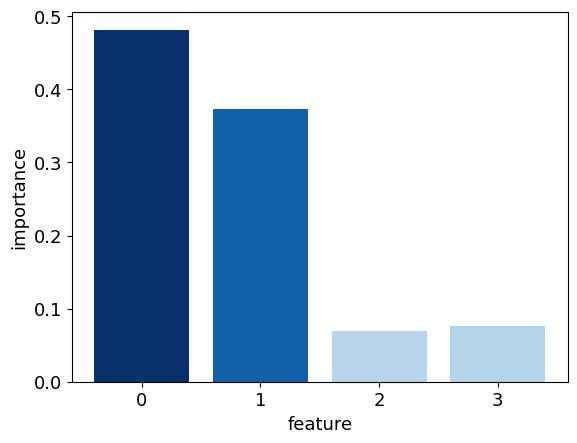

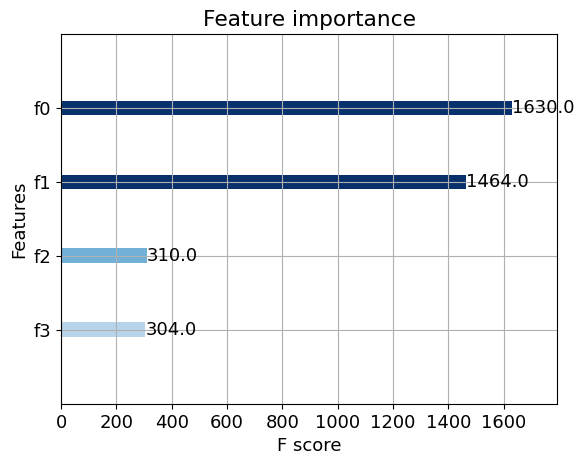

In [13]:
my_cmap = plt.get_cmap("Blues")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))

plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
plt.show()

In [14]:
original_model = XGBClassifier(gamma =  best_params['gamma'], learning_rate = best_params['learning_rate'], max_depth = 6, n_estimators = 150, reg_lambda = 0.01, reg_alpha = 0.01, seed=1, objective='binary:logistic')
original_model.fit(x_train, y_train)

least_important_features_indices = 2,3
x_train_reduced = np.delete(x_train, least_important_features_indices, axis=1)

reduced_model = XGBClassifier(gamma =  best_params['gamma'], learning_rate = best_params['learning_rate'], max_depth = 6, n_estimators = 150, reg_lambda = 0.01, reg_alpha = 0.01, seed=1, objective='binary:logistic')
reduced_model.fit(x_train_reduced, y_train)

# Evaluate both models on the test data
y_pred_original = original_model.predict(x_val)
accuracy_original = accuracy_score(y_val, y_pred_original)

y_pred_reduced = reduced_model.predict(np.delete(x_val, least_important_features_indices, axis=1))
accuracy_reduced = accuracy_score(y_val, y_pred_reduced)

print(f"Accuracy with all features: {accuracy_original}")
print(f"Accuracy with reduced features: {accuracy_reduced}")

Accuracy with all features: 0.945
Accuracy with reduced features: 0.955


Accuracy after removing features [0]: 0.621
Accuracy after removing features [1]: 0.581
Accuracy after removing features [2]: 0.939
Accuracy after removing features [3]: 0.938
Accuracy after removing features [0, 1]: 0.522
Accuracy after removing features [1, 2]: 0.578
Accuracy after removing features [2, 3]: 0.955
Accuracy after removing features [0, 2]: 0.61
Accuracy after removing features [0, 3]: 0.596
Accuracy after removing features [1, 3]: 0.575


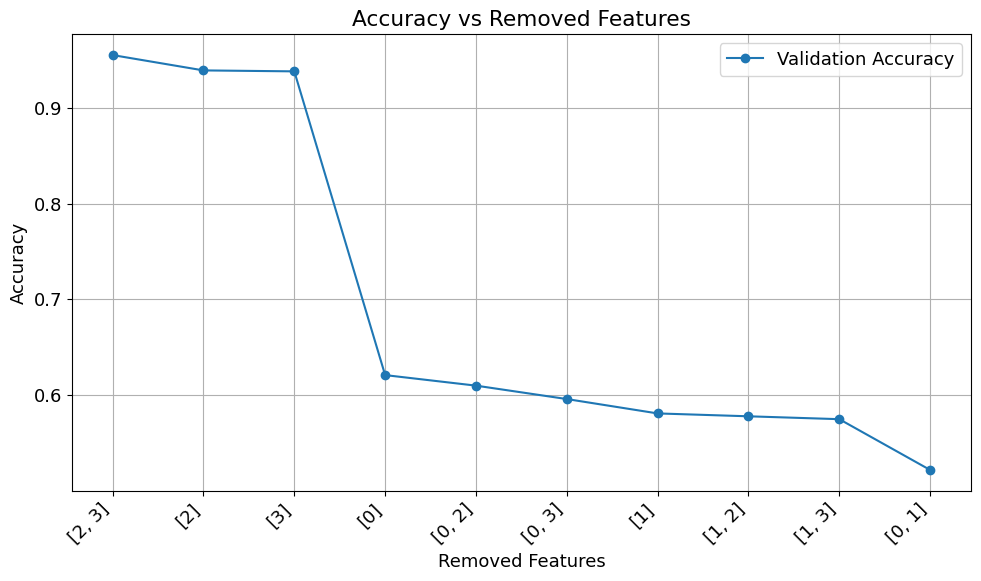

In [15]:
least_important_features_indices = [[0], [1], [2], [3], [0, 1], [1, 2], [2, 3], [0, 2], [0, 3], [1, 3]]
accuracies = []

for indices in least_important_features_indices:
    x_train_reduced = np.delete(x_train, indices, axis=1)
    x_val_reduced = np.delete(x_val, indices, axis=1)

    reduced_model = XGBClassifier(gamma =  best_params['gamma'], learning_rate = best_params['learning_rate'], max_depth = 6, n_estimators = 150, reg_lambda = 0.01, reg_alpha = 0.01, seed=1, objective='binary:logistic')
    reduced_model.fit(x_train_reduced, y_train)
    
    y_pred_reduced = reduced_model.predict(x_val_reduced)
    accuracy_reduced = accuracy_score(y_val, y_pred_reduced)
    accuracies.append(accuracy_reduced)
    
for i, indices in enumerate(least_important_features_indices):
    print(f"Accuracy after removing features {indices}: {accuracies[i]}")

sorted_indices=sorted(range(len(accuracies)), key=lambda k: accuracies[k])
accuracies=[accuracies[i] for i in sorted_indices]

labels = [str(indices) for indices in least_important_features_indices]
labels=[labels[i] for i in sorted_indices]


plt.figure(figsize=(10, 6))
plt.plot(labels, accuracies, marker='o', label='Validation Accuracy')
plt.title('Accuracy vs Removed Features')
plt.xlabel('Removed Features')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.gca().invert_xaxis()

plt.show()

### Answer

From the previous results we can see that the exclusion of the least important features (either both 2 and 3 or one between 2 and 3) lead to a better validation accuracy. This is due to the fact that these features don't add anithing important to the dataset, so we can just forget about them and our model will predict with an higher efficiency.

### 3\.  XGBoost vs NN
Compare the validation accuracy of XGBoost with that of a simple feed-forward neural network (NN):
- By varying the number of data samples N’ in the training set (i.e., reducing the fraction N’/N of the data set used for training)
- With cross-validation for all cases.

Is the NN or the XGB performing significantly better at low N’?